In [4]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from climakitae.core.data_interface import get_data

LAT_SLICE = (34.6, 35.8)
LON_SLICE = (-117.4, -115.6)

BASELINE = (1995, 2014)
FUTURE = (2070, 2099)

SCENARIOS = [
    'Historical Climate',
    'SSP 2-4.5',
    'SSP 3-7.0',
    'SSP 5-8.5',
]

COLORS = {
    'Historical Climate': '#8fbbe8',
    'SSP 1-2.6': '#5c7bd6',
    'SSP 2-4.5': '#6ea0ff',
    'SSP 3-7.0': '#3b348b',
    'SSP 5-8.5': '#a34b4b',
}

In [5]:
def ensure_celsius(da: xr.DataArray) -> xr.DataArray:
    if da.attrs.get('units', '').lower().startswith('k'):
        da = da - 273.15
        da.attrs['units'] = '°C'
    return da

def fetch_box(variable: str, scenario: str):
    for method, res in [("Statistical", "3 km"), ("Dynamical", "3 km")]:
        try:
            ds = get_data(
                variable=variable,
                downscaling_method=method,
                resolution=res,
                timescale="monthly",
                scenario=scenario,
                time_slice=(1980, 2100),
                latitude=LAT_SLICE,
                longitude=LON_SLICE,
            )
        except (KeyError, ValueError):
            continue
        if ds is None or getattr(ds, "time", None) is None or ds.time.size == 0:
            continue
        da = ds[list(ds.data_vars)[0]] if isinstance(ds, xr.Dataset) else ds
        spatial = [d for d in da.dims if d not in ("time", "scenario", "simulation", "member", "realization")]
        if spatial:
            da = da.mean(dim=spatial)
        return ensure_celsius(da)
    return None

def seasonal_30yr(da: xr.DataArray, y0: int, y1: int):
    win = da.sel(time=slice(f'{y0}-01-01', f'{y1}-12-31'))
    if getattr(win, 'time', None) is None or win.time.size == 0:
        return None, None
    monthly = win.groupby('time.month').mean('time')
    if 'simulation' in monthly.dims:
        mean = monthly.mean('simulation')
        std = monthly.std('simulation')
    else:
        mean = monthly
        std  = xr.zeros_like(monthly)
    months = np.arange(1, 13)
    return np.ravel(mean.sel(month=months).values), np.ravel(std.sel(month=months).values)

ERROR: No data found for your input values. Please modify your data request. 
Returning None
ERROR: No data found for your input values. Please modify your data request. 
Returning None
ERROR: No data found for your input values. Please modify your data request. 
Returning None
[skip] SSP 2-4.5: no data
ERROR: No data found for your input values. Please modify your data request. 
Returning None
ERROR: No data found for your input values. Please modify your data request. 
Returning None
ERROR: No data found for your input values. Please modify your data request. 
Returning None
[skip] SSP 5-8.5: no data


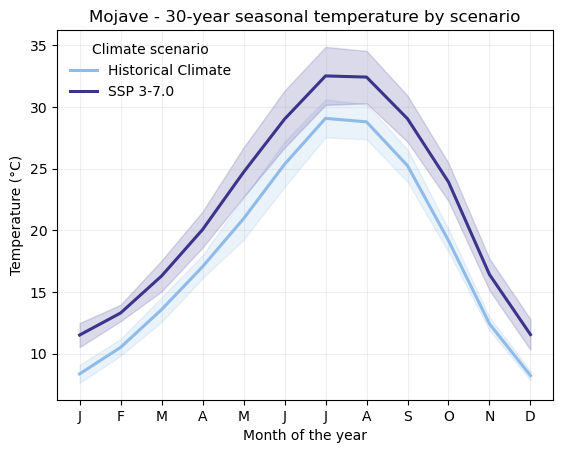

In [6]:
curves = []
for scen in SCENARIOS:
    window = BASELINE if scen == 'Historical Climate' else FUTURE
    da = fetch_box('Air Temperature at 2m', scen)
    if da is None:
        print(f'[skip] {scen}: no data')
        continue
    m, s = seasonal_30yr(da, *window)
    if m is None:
        print(f'[skip] {scen}: empty window {window}')
        continue
    curves.append((scen, m, s))

months = np.arange(1, 13)
fig, ax = plt.subplots()

for scen, m, s in curves:
    c = COLORS.get(scen, None)
    ax.plot(months, m, label=scen, linewidth=2.2, color=c)
    ax.fill_between(months, m - s, m + s, alpha=0.18, color=c)

ax.set_xticks(months)
ax.set_xticklabels(list('JFMAMJJASOND'))
ax.set_xlabel('Month of the year')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Mojave - 30-year seasonal temperature by scenario')
ax.legend(title='Climate scenario', frameon=False)
ax.grid(alpha=0.2)
plt.show()